In [1]:
import numpy as np
from gymnasium.envs.mujoco.pusher_v5 import PusherEnv
from gymnasium.spaces import Box


class CRLPusherEnv(PusherEnv):
    """
    Pusher con no-estacionariedad por material.

    El tipo de material modifica las propiedades físicas del objeto
    (masa, fricción, amortiguamiento) y los pesos de recompensa,
    creando un entorno no-estacionario cuando se alterna durante
    el entrenamiento.

    Recompensa = base_pusher_reward + progress_shaping + success_bonus
    Observación = obs_pusher + one_hot(material)

    base_pusher_reward ya incluye:
      -dist(obj,goal) - 0.5*dist(tip,obj) - 0.1*||action||²
    Esto provee el gradiente continuo que PPO necesita para:
      1) Acercar la punta al objeto
      2) Empujar el objeto hacia el goal
    """

    MATERIALS = {
        "rigid": dict(
            physics=dict(
                gravity_z=-9.81,
                damping_scale=1.3,
                frictionloss_scale=1.2,
                object_mass_scale=1.8,
                object_sliding_friction_scale=1.4,
            ),
            reward=dict(
                w_progress=15.0,
                success_bonus=50.0,
                success_threshold=0.12,
            ),
        ),
        "delicate": dict(
            physics=dict(
                gravity_z=-9.81,
                damping_scale=0.7,
                frictionloss_scale=0.5,
                object_mass_scale=0.5,
                object_sliding_friction_scale=0.4,
            ),
            reward=dict(
                w_progress=20.0,
                success_bonus=60.0,
                success_threshold=0.12,
            ),
        ),
    }

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

        self.material = "rigid"

        # IDs del objeto en el modelo MuJoCo
        self.obj_body_id = self.model.body("object").id
        self.obj_geom_id = self.model.body_geomadr[self.obj_body_id]

        # Guardar física base para poder restaurar
        self._base_gravity = self.model.opt.gravity.copy()
        self._base_dof_damping = self.model.dof_damping.copy()
        self._base_dof_frictionloss = self.model.dof_frictionloss.copy()
        self._base_body_mass = self.model.body_mass.copy()
        self._base_geom_friction = self.model.geom_friction.copy()

        # Parámetros de recompensa (se sobrescriben por set_material)
        self.w_progress = 15.0
        self.success_bonus = 50.0
        self.success_threshold = 0.12

        # Estado interno del episodio
        self.prev_obj_goal_dist = None
        self.episode_steps = 0

        # Extender espacio de observación con one-hot de material (2 dims)
        base_low = self.observation_space.low
        base_high = self.observation_space.high
        self.observation_space = Box(
            low=np.concatenate([base_low, np.zeros(2, dtype=base_low.dtype)]),
            high=np.concatenate([base_high, np.ones(2, dtype=base_high.dtype)]),
            dtype=base_low.dtype,
        )

        self.set_material("rigid")

    # ── Observaciones ──────────────────────────────────────────────

    def _material_one_hot(self):
        idx = list(self.MATERIALS.keys()).index(self.material)
        oh = np.zeros(len(self.MATERIALS), dtype=self.observation_space.dtype)
        oh[idx] = 1.0
        return oh

    def _get_obs(self):
        return np.concatenate(
            [super()._get_obs(), self._material_one_hot()]
        ).astype(self.observation_space.dtype)

    # ── Distancia objeto → goal ────────────────────────────────────

    def _get_obj_goal_distance(self):
        obj_pos = self.get_body_com("object")
        goal_pos = self.get_body_com("goal")
        return float(np.linalg.norm(obj_pos - goal_pos))

    # ── Configuración de física ────────────────────────────────────

    def set_physics(
        self,
        *,
        gravity_z=-9.81,
        damping_scale=1.0,
        frictionloss_scale=1.0,
        object_mass_scale=1.0,
        object_sliding_friction_scale=1.0,
    ):
        self.model.opt.gravity[:] = self._base_gravity
        self.model.opt.gravity[2] = gravity_z

        self.model.dof_damping[:] = self._base_dof_damping * damping_scale
        self.model.dof_frictionloss[:] = (
            self._base_dof_frictionloss * frictionloss_scale
        )

        self.model.body_mass[:] = self._base_body_mass
        self.model.body_mass[self.obj_body_id] = (
            self._base_body_mass[self.obj_body_id] * object_mass_scale
        )

        self.model.geom_friction[:] = self._base_geom_friction
        self.model.geom_friction[self.obj_geom_id, 0] = (
            self._base_geom_friction[self.obj_geom_id, 0]
            * object_sliding_friction_scale
        )

    def set_material(self, name: str):
        if name not in self.MATERIALS:
            raise ValueError(
                f"Material '{name}' no existe. Opciones: {list(self.MATERIALS.keys())}"
            )
        cfg = self.MATERIALS[name]
        self.set_physics(**cfg["physics"])

        rw = cfg["reward"]
        self.w_progress = rw["w_progress"]
        self.success_bonus = rw["success_bonus"]
        self.success_threshold = rw["success_threshold"]
        self.material = name

    # ── Reset ──────────────────────────────────────────────────────

    def reset(self, *, seed=None, options=None):
        obs, info = super().reset(seed=seed, options=options)

        if options and "material" in options:
            self.set_material(options["material"])

        self.prev_obj_goal_dist = self._get_obj_goal_distance()
        self.episode_steps = 0

        obs = self._get_obs()
        info["material"] = self.material
        info["distance_to_goal"] = self.prev_obj_goal_dist
        return obs, info

    # ── Step ───────────────────────────────────────────────────────

    def step(self, action):
        # Capturar base_reward de PusherEnv (antes se descartaba con _)
        # base_reward = -dist(obj,goal) - 0.5*dist(tip,obj) - 0.1*||a||²
        obs, base_reward, terminated, truncated, info = super().step(action)
        self.episode_steps += 1

        obj_goal_dist = self._get_obj_goal_distance()
        if self.prev_obj_goal_dist is None:
            self.prev_obj_goal_dist = obj_goal_dist

        # Progress shaping: recompensar acercamiento del objeto al goal
        progress = self.prev_obj_goal_dist - obj_goal_dist
        progress_reward = self.w_progress * np.clip(progress, -0.02, 0.02)

        # Bonus de éxito
        is_success = obj_goal_dist <= self.success_threshold
        success_reward = self.success_bonus if is_success else 0.0

        # Recompensa total: base probada + shaping + éxito
        reward = base_reward + progress_reward + success_reward

        if is_success:
            terminated = True

        self.prev_obj_goal_dist = obj_goal_dist
        obs = self._get_obs()

        tip_pos = self.get_body_com("tips_arm")
        obj_pos = self.get_body_com("object")
        tip_obj_dist = float(np.linalg.norm(tip_pos - obj_pos))

        info.update(
            {
                "material": self.material,
                "distance_to_goal": obj_goal_dist,
                "is_success": float(is_success),
                "episode_steps": self.episode_steps,
                "progress": progress,
                "tip_to_obj_distance": tip_obj_dist,
                "reward_base": float(base_reward),
                "reward_progress": float(progress_reward),
                "reward_success": float(success_reward),
            }
        )

        return obs, reward, terminated, truncated, info

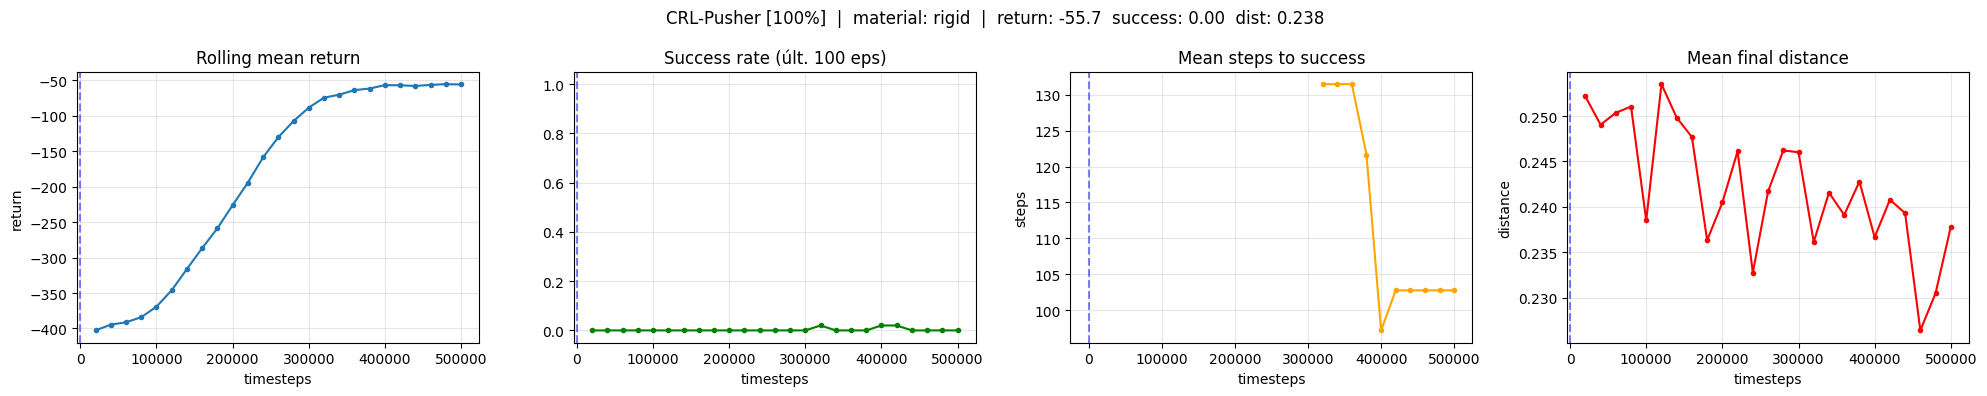


✓ Entrenamiento completado en 6.8 min

─── Evaluación DESPUÉS del entrenamiento ───
  [   rigid]  return=-49.12  success=0.00  steps=nan  dist=0.2181
  [delicate]  return=-64.14  success=0.00  steps=nan  dist=0.2406


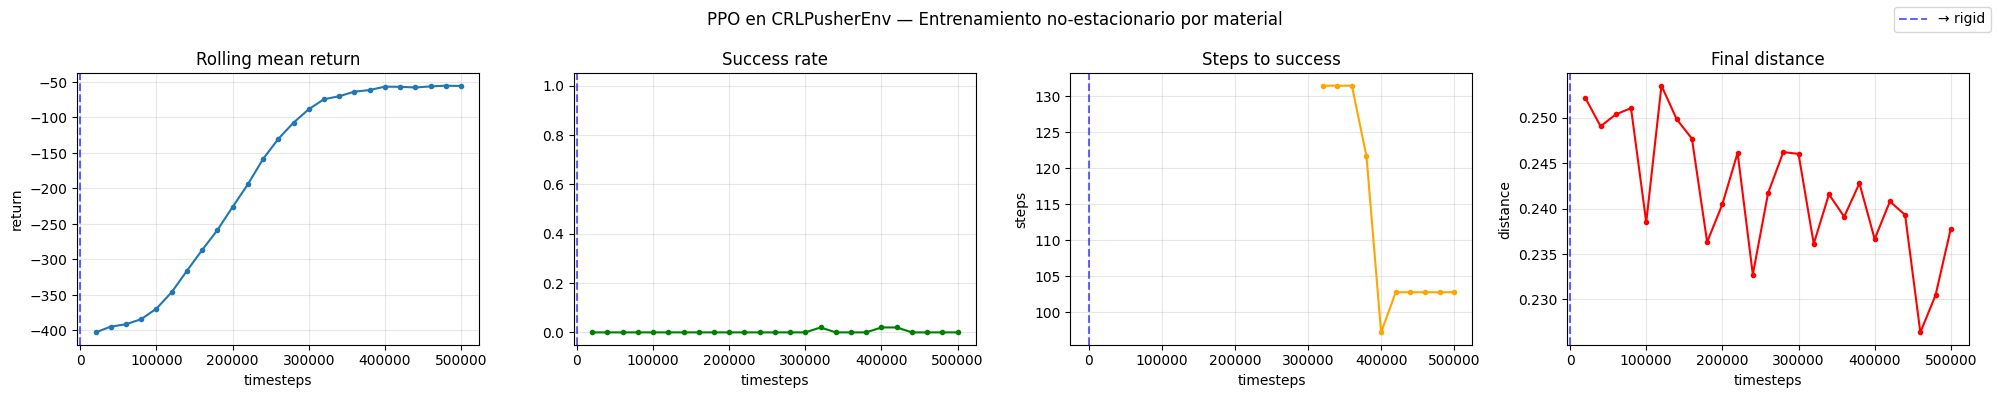

In [2]:
%matplotlib inline

import os, shutil, time
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from IPython.display import display, clear_output

os.environ["CUDA_VISIBLE_DEVICES"] = ""

from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import BaseCallback, CallbackList

# ═══════════════════════════════════════════════════════════════════
# Configuración
# ═══════════════════════════════════════════════════════════════════

LOG_DIR = "./logs/pusher_crl_v4"
if os.path.exists(LOG_DIR):
    shutil.rmtree(LOG_DIR)
os.makedirs(LOG_DIR, exist_ok=True)

MAX_EPISODE_STEPS = 150
TOTAL_STEPS = 1_000_000

PRETRAIN_STATIONARY = True

if PRETRAIN_STATIONARY:
    # Fase base: primero aprender a empujar al target en régimen estacionario.
    SCHEDULE = [(0, "rigid")]
else:
    SCHEDULE = [
        (0,       "delicate"),
        (200_000, "rigid"),
        (350_000, "delicate"),
    ]

# ═══════════════════════════════════════════════════════════════════
# Callbacks
# ═══════════════════════════════════════════════════════════════════

class NonStationaryMaterialCallback(BaseCallback):
    """Cambia el material del entorno según un schedule de timesteps."""

    def __init__(self, schedule, verbose=1):
        super().__init__(verbose)
        self.schedule = sorted(schedule, key=lambda x: x[0])
        self._next_idx = 0
        self.applied_changes = []

    def _on_step(self) -> bool:
        while (
            self._next_idx < len(self.schedule)
            and self.num_timesteps >= self.schedule[self._next_idx][0]
        ):
            _, material = self.schedule[self._next_idx]
            self.training_env.env_method("set_material", material)
            self.applied_changes.append((self.num_timesteps, material))
            if self.verbose:
                print(
                    f"\n{'='*60}\n"
                    f"  [CAMBIO MATERIAL] t={self.num_timesteps:,} → {material}\n"
                    f"{'='*60}\n"
                )
            self._next_idx += 1
        return True


class LivePlotCallback(BaseCallback):
    """
    Gráficas en vivo + heartbeat de texto durante el entrenamiento.
    Usa display() para rendering confiable en VS Code notebooks.
    """

    def __init__(self, plot_freq=20_000, heartbeat_freq=5_000,
                 total_steps=1_000_000, verbose=1):
        super().__init__(verbose)
        self.plot_freq = plot_freq
        self.heartbeat_freq = heartbeat_freq
        self.total_steps = total_steps
        self.last_plot_step = 0
        self.last_hb_step = 0

        # Series para gráficas
        self.ts = []
        self.returns = []
        self.success_rates = []
        self.steps_to_success = []
        self.final_distances = []

        # Acumuladores de episodios
        self._successes = []
        self._succ_steps = []
        self._final_dists = []

        # Cambios de material (inyectados externamente)
        self.material_changes = []

    def _extract_ep_info(self, info):
        """Extrae info del episodio terminal, buscando en terminal_info si existe."""
        ti = info.get("terminal_info", info)
        return {
            "is_success": float(ti.get("is_success", 0.0)),
            "distance_to_goal": float(ti.get("distance_to_goal", np.nan)),
            "episode_steps": float(ti.get("episode_steps", np.nan)),
        }

    def _on_step(self) -> bool:
        dones = self.locals.get("dones", [])
        infos = self.locals.get("infos", [])

        for done, info in zip(dones, infos):
            if not done:
                continue
            ep = self._extract_ep_info(info)
            self._successes.append(ep["is_success"])
            if not np.isnan(ep["distance_to_goal"]):
                self._final_dists.append(ep["distance_to_goal"])
            if ep["is_success"] > 0.5 and not np.isnan(ep["episode_steps"]):
                self._succ_steps.append(ep["episode_steps"])

        # ── Heartbeat (texto) ──────────────────────────────────────
        if (self.num_timesteps - self.last_hb_step) >= self.heartbeat_freq:
            self.last_hb_step = self.num_timesteps
            pct = 100.0 * self.num_timesteps / self.total_steps
            sr = np.mean(self._successes[-50:]) if self._successes else 0.0
            md = np.mean(self._final_dists[-50:]) if self._final_dists else np.nan
            try:
                mat = self.training_env.get_attr("material")[0]
            except Exception:
                mat = "?"
            print(
                f"  [{pct:5.1f}%] t={self.num_timesteps:>8,}  "
                f"sr={sr:.2f}  dist={md:.3f}  material={mat}"
            )

        # ── Gráfica (cada plot_freq) ──────────────────────────────
        if (self.num_timesteps - self.last_plot_step) < self.plot_freq:
            return True
        self.last_plot_step = self.num_timesteps

        if not self.model.ep_info_buffer:
            return True

        mean_r = float(np.mean([e["r"] for e in self.model.ep_info_buffer]))
        sr = np.mean(self._successes[-100:]) if self._successes else 0.0
        mts = np.mean(self._succ_steps[-100:]) if self._succ_steps else np.nan
        mfd = np.mean(self._final_dists[-100:]) if self._final_dists else np.nan

        self.ts.append(self.num_timesteps)
        self.returns.append(mean_r)
        self.success_rates.append(float(sr))
        self.steps_to_success.append(float(mts))
        self.final_distances.append(float(mfd))

        # Limpiar output y redibujar
        clear_output(wait=True)

        fig, axes = plt.subplots(1, 4, figsize=(20, 4))

        axes[0].plot(self.ts, self.returns, "o-", ms=3)
        axes[0].set_title("Rolling mean return")
        axes[0].set_xlabel("timesteps"); axes[0].set_ylabel("return")
        axes[0].tick_params(axis='x', rotation=45)

        axes[1].plot(self.ts, self.success_rates, "o-", ms=3, color="green")
        axes[1].set_title("Success rate (últ. 100 eps)")
        axes[1].set_xlabel("timesteps"); axes[1].set_ylim(-0.05, 1.05)
        axes[1].tick_params(axis='x', rotation=45)

        axes[2].plot(self.ts, self.steps_to_success, "o-", ms=3, color="orange")
        axes[2].set_title("Mean steps to success")
        axes[2].set_xlabel("timesteps"); axes[2].set_ylabel("steps")
        axes[2].tick_params(axis='x', rotation=45)

        axes[3].plot(self.ts, self.final_distances, "o-", ms=3, color="red")
        axes[3].set_title("Mean final distance")
        axes[3].set_xlabel("timesteps"); axes[3].set_ylabel("distance")
        axes[3].tick_params(axis='x', rotation=45)

        # Líneas de cambio de material
        for ax in axes:
            for ts_c, mat_c in self.material_changes:
                ax.axvline(ts_c, ls="--", alpha=0.5,
                           color="red" if mat_c == "delicate" else "blue")
            ax.grid(alpha=0.3)

        try:
            mat = self.training_env.get_attr("material")[0]
        except Exception:
            mat = "?"
        pct = 100.0 * self.num_timesteps / self.total_steps
        fig.suptitle(
            f"CRL-Pusher [{pct:.0f}%]  |  material: {mat}  |  "
            f"return: {mean_r:.1f}  success: {sr:.2f}  dist: {mfd:.3f}"
        )
        plt.tight_layout()
        display(fig)
        plt.close(fig)

        return True


# ═══════════════════════════════════════════════════════════════════
# Crear entornos
# ═══════════════════════════════════════════════════════════════════

def make_env(material="rigid", log_path=None):
    env = CRLPusherEnv()
    env = gym.wrappers.TimeLimit(env, max_episode_steps=MAX_EPISODE_STEPS)
    info_kw = (
        "is_success",
        "distance_to_goal",
        "episode_steps",
        "material",
        "progress",
        "tip_to_obj_distance",
        "reward_base",
        "reward_progress",
        "reward_success",
    )
    env = Monitor(env, log_path or LOG_DIR, info_keywords=info_kw)
    env.reset(options={"material": material})
    return env


train_env = make_env("rigid")
eval_env = make_env("rigid", log_path=os.path.join(LOG_DIR, "eval"))


# ═══════════════════════════════════════════════════════════════════
# Modelo PPO
# ═══════════════════════════════════════════════════════════════════

model = PPO(
    "MlpPolicy",
    train_env,
    verbose=0,
    tensorboard_log=os.path.join(LOG_DIR, "tb"),
    learning_rate=2e-4,
    n_steps=2048,
    batch_size=64,
    n_epochs=10,
    gamma=0.99,
    gae_lambda=0.95,
    clip_range=0.2,
    ent_coef=0.005,
    use_sde=True,
    sde_sample_freq=4,
    device="cpu",
)


# ═══════════════════════════════════════════════════════════════════
# Evaluación
# ═══════════════════════════════════════════════════════════════════

def evaluate(model, env, material, n_episodes=20):
    successes, rets, succ_steps, dists = 0, [], [], []
    for _ in range(n_episodes):
        obs, _ = env.reset(options={"material": material})
        done, ep_ret, last = False, 0.0, {}
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, r, term, trunc, last = env.step(action)
            done = term or trunc
            ep_ret += r
        rets.append(ep_ret)
        dists.append(last.get("distance_to_goal", np.nan))
        if last.get("is_success", 0.0) > 0.5:
            successes += 1
            succ_steps.append(last.get("episode_steps", np.nan))
    return dict(
        mean_return=float(np.mean(rets)),
        success_rate=successes / n_episodes,
        mean_steps=float(np.mean(succ_steps)) if succ_steps else np.nan,
        mean_dist=float(np.nanmean(dists)),
    )


# ═══════════════════════════════════════════════════════════════════
# Evaluación ANTES
# ═══════════════════════════════════════════════════════════════════

print("─── Evaluación ANTES del entrenamiento ───")
for mat in ["rigid", "delicate"]:
    res = evaluate(model, eval_env, mat, n_episodes=10)
    print(f"  [{mat:>8s}]  return={res['mean_return']:.2f}  "
          f"success={res['success_rate']:.2f}  dist={res['mean_dist']:.4f}")
print()


# ═══════════════════════════════════════════════════════════════════
# Entrenamiento
# ═══════════════════════════════════════════════════════════════════

switch_cb = NonStationaryMaterialCallback(SCHEDULE, verbose=1)
plot_cb = LivePlotCallback(
    plot_freq=20_000,
    heartbeat_freq=5_000,
    total_steps=TOTAL_STEPS,
)

# Conectar cambios de material al plot
class _LinkCallbacks(BaseCallback):
    def __init__(self, switch_cb, plot_cb):
        super().__init__(verbose=0)
        self._switch = switch_cb
        self._plot = plot_cb
        self._seen = 0

    def _on_step(self) -> bool:
        n = len(self._switch.applied_changes)
        if n > self._seen:
            for c in self._switch.applied_changes[self._seen:]:
                self._plot.material_changes.append(c)
            self._seen = n
        return True

link_cb = _LinkCallbacks(switch_cb, plot_cb)
callbacks = CallbackList([switch_cb, link_cb, plot_cb])

print(f"Iniciando entrenamiento: {TOTAL_STEPS:,} steps")
print(f"Schedule de materiales: {SCHEDULE}\n")

t0 = time.time()
model.learn(total_timesteps=TOTAL_STEPS, callback=callbacks, progress_bar=False)
elapsed = time.time() - t0
print(f"\n✓ Entrenamiento completado en {elapsed/60:.1f} min")


# ═══════════════════════════════════════════════════════════════════
# Evaluación DESPUÉS
# ═══════════════════════════════════════════════════════════════════

print("\n─── Evaluación DESPUÉS del entrenamiento ───")
for mat in ["rigid", "delicate"]:
    res = evaluate(model, eval_env, mat, n_episodes=20)
    print(f"  [{mat:>8s}]  return={res['mean_return']:.2f}  "
          f"success={res['success_rate']:.2f}  "
          f"steps={res['mean_steps']:.1f}  dist={res['mean_dist']:.4f}")


# ═══════════════════════════════════════════════════════════════════
# Gráfica final
# ═══════════════════════════════════════════════════════════════════

fig, axes = plt.subplots(1, 4, figsize=(20, 4))

axes[0].plot(plot_cb.ts, plot_cb.returns, "o-", ms=3)
axes[0].set_title("Rolling mean return"); axes[0].set_ylabel("return")

axes[1].plot(plot_cb.ts, plot_cb.success_rates, "o-", ms=3, color="green")
axes[1].set_title("Success rate"); axes[1].set_ylim(-0.05, 1.05)

axes[2].plot(plot_cb.ts, plot_cb.steps_to_success, "o-", ms=3, color="orange")
axes[2].set_title("Steps to success"); axes[2].set_ylabel("steps")

axes[3].plot(plot_cb.ts, plot_cb.final_distances, "o-", ms=3, color="red")
axes[3].set_title("Final distance"); axes[3].set_ylabel("distance")

for ax in axes:
    ax.set_xlabel("timesteps")
    for ts_c, mat_c in switch_cb.applied_changes:
        ax.axvline(ts_c, ls="--", alpha=0.6,
                   color="red" if mat_c == "delicate" else "blue",
                   label=f"→ {mat_c}")
    ax.grid(alpha=0.3)

handles, labels = axes[0].get_legend_handles_labels()
by_label = dict(zip(labels, handles))
fig.legend(by_label.values(), by_label.keys(), loc="upper right")
fig.suptitle("PPO en CRLPusherEnv — Entrenamiento no-estacionario por material")
plt.tight_layout()
display(fig)
plt.close(fig)

train_env.close()
eval_env.close()

In [3]:
import time

# Visualización de la política final en ambos materiales
env = CRLPusherEnv(render_mode="human")

for material in ["rigid", "delicate"]:
    print(f"\n{'='*40}")
    print(f"[Rollout] material = {material}")
    print(f"{'='*40}")
    obs, info = env.reset(options={"material": material})
    success_count = 0
    episode_count = 0

    for step in range(3000):
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = env.step(action)
        time.sleep(1 / 30)

        if terminated or truncated:
            episode_count += 1
            if info.get("is_success", 0.0) > 0.5:
                success_count += 1
            obs, info = env.reset(options={"material": material})

    print(f"  Episodes: {episode_count}  |  Successes: {success_count}  "
          f"|  Rate: {success_count/max(episode_count,1):.2f}")

env.close()


[Rollout] material = rigid


/home/raul/Escritorio/extra/misis/.venv/lib/python3.12/site-packages/glfw/__init__.py:917: GLFWError: (65537) b'The GLFW library is not initialized'
  warnings.warn(message, GLFWError)


KeyboardInterrupt: 